In [1]:
import cv2 as cv
import numpy as np
import copy
from matplotlib import pyplot as plt
from utils import Splitter
import math

In [2]:
def SIFT(
    img, min_s=0, flags=cv.DrawMatchesFlags_DEFAULT, color=-1, SIFT_draw=True
):
    sift = cv.SIFT_create()
    c_img = img.copy()
    
    kp, des = sift.detectAndCompute(c_img, None)
    kp_des = [v for v in zip(kp, des) if v[0].size >= min_s]

    [kp, des] = zip(*kp_des)
    if SIFT_draw:
        img = cv.drawKeypoints(c_img, kp, img, color=color,flags=flags)
    else:
        img = c_img

    return img, (kp, np.array(des))

def pad_y(split1, split2):
    (y1, x1), (y2, x2) = split1.shape[:2], split2.shape[:2]
    if y1 > y2:
        padimg = np.full_like([], 255, shape=(y1, x2, 3), dtype=np.uint8)
        padimg[0:y2] = split2
        split2 = padimg
    elif y2 > y1:
        padimg = np.full_like([], 255, shape=(y2, x1, 3), dtype=np.uint8)
        padimg[0:y1] = split1
        split1 = padimg
        
    return split1, split2

def register(sift_data, split1, split2, thresh=0.5):
    split1, split2 = pad_y(split1, split2)
    [(kp1, des1), (kp2, des2)] = sift_data
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test
    matches = np.array(
        [[m] for m, n in matches if m.distance < thresh * n.distance]
    )
    
    # kp registration

    # compute H matrix
    if not matches.shape[0]:
        raise AssertionError("No keypoints found")
    if len(matches[:, 0]) >= 5:
        qp = np.float32(
            [kp1[m.queryIdx].pt for m in matches[:, 0]]).reshape(-1,1,2)
        tp = np.float32(
            [kp2[m.trainIdx].pt for m in matches[:, 0]]).reshape(-1,1,2)
        H, _ = cv.findHomography(qp, tp, cv.RANSAC, 5.0)
    else:
        raise AssertionError("Not enough keypoints. \
            Try applying a different transformation")

    reg = cv.drawMatchesKnn(
        split1, kp1,
        split2, kp2,
        matches, None,
        matchColor = (0, 0, 255),
        flags = cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    return reg, H


In [3]:
def composite(H, split1, split2):
    [y1, x1] = split1.shape[:2]
    [y2, x2] = split2.shape[:2]
    
    qp = np.float32([[0, 0], [0, y2], [x2, y2], [x2, 0]]).reshape(-1,1,2)
    tp = np.float32([[0, 0], [0, y1], [x1, y1], [x1, 0]]).reshape(-1,1,2)
    tp = cv.perspectiveTransform(tp, H)
    
    pts = np.concatenate((qp, tp), axis = 0)    
    H_min = np.int32(pts.min(axis = 0).flatten())
    H_max = np.int32(pts.max(axis = 0).flatten())
    t = np.int32([-H_min[0], -H_min[1]]) 
    Ht = np.array([
        [1, 0, t[0]],
        [0, 1, t[1]],
        [0, 0, 1   ]
    ])

    warped = cv.warpPerspective(
        split1, Ht.dot(H),
        (H_max[0] - H_min[0], H_max[1] - H_min[1]),
        borderValue=(255,255,255)
    )
    
    # img[0][0] & [255, 255, 255] == img[0][0]
    w_left = warped[t[1]:y2 + t[1], t[0]:x2 + t[0]] & split2
    warp_gray = cv.cvtColor(w_left, cv.COLOR_BGR2GRAY)
    _, mask = cv.threshold(warp_gray, 0, 255, cv.THRESH_BINARY)
    w_right = cv.bitwise_and(split2, split2, mask = ~mask)
    warped[t[1]:y2 + t[1], t[0]:x2 + t[0]] = w_left + w_right
    
    return warped

In [4]:
def view_matches(splits, data, axis=1):
    r_s, c_s = splits.r_split, splits.c_split
    splits = copy.deepcopy(splits)
    _, axes = plt.subplots(r_s, 1, figsize=(20,20))

    for i, s_row in enumerate(splits):
        max_y, H_row = 0, []
        for j in range(c_s - 1):
            s1, s2 = s_row[j], s_row[j + 1]
            res, _ = register(data[i][j:j + 2], s1, s2)
            s1, s2 = res[:, :s1.shape[1]], res[:, s1.shape[1]:]
            s_row[j:j + 2] = s1, s2
            if s1.shape[0] > s_row[max_y].shape[0]: max_y = i
        row = None
        for j in range(c_s):
            s_row[j], _ = pad_y(s_row[j], s_row[max_y])
            if j == 0:
                row = s_row[j]
                continue
            row = np.concatenate((row, s_row[j]), axis=1)
        if r_s > 1:
            axes[i].imshow(row)
        else: 
            axes.imshow(row)

In [5]:
TEST_IMG = "test2.jpeg"

src = cv.imread(TEST_IMG)
if src is None:
    print('Could not open or find the image:', TEST_IMG)
    exit(0)

img = src.copy()
r_split, c_split, split_size = 2, 3, 150
splits = Splitter(img, r_split, c_split, split_size)
splits.draw_splits(rects=True, alpha=0.15, mod_orig=True)
splits.draw_splits(mod_orig=True)

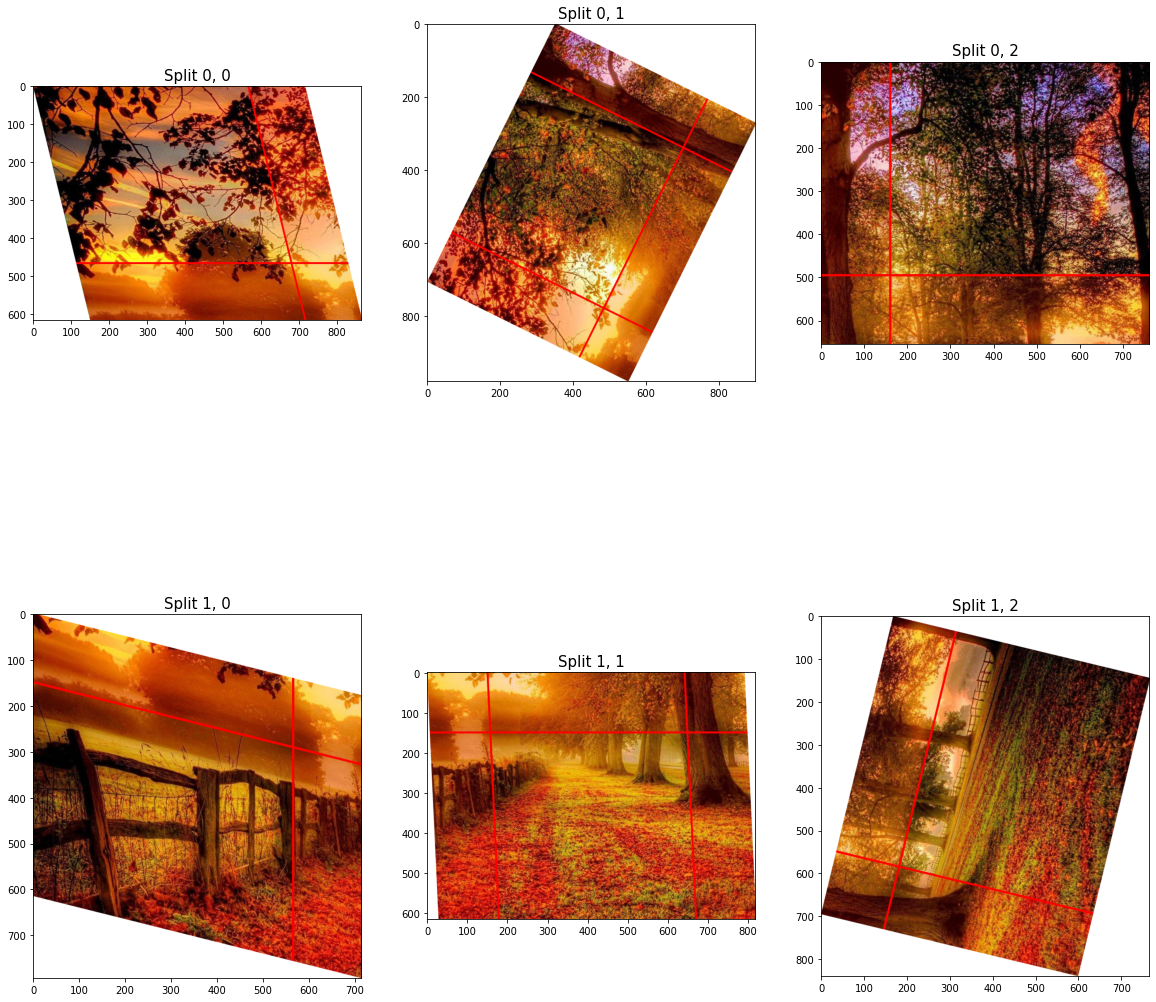

In [10]:
from utils import scale, rotation, shear
rand_transform = [scale, rotation, shear]
# rand_transform = [rotation]

splits.restore()
for i in range(r_split):
    for j in range(c_split):
        rand = np.random.randint(0, len(rand_transform))
        transform = rand_transform[rand]
        splits.apply(transform, i, j)

splits = copy.deepcopy(splits)
splits.show()

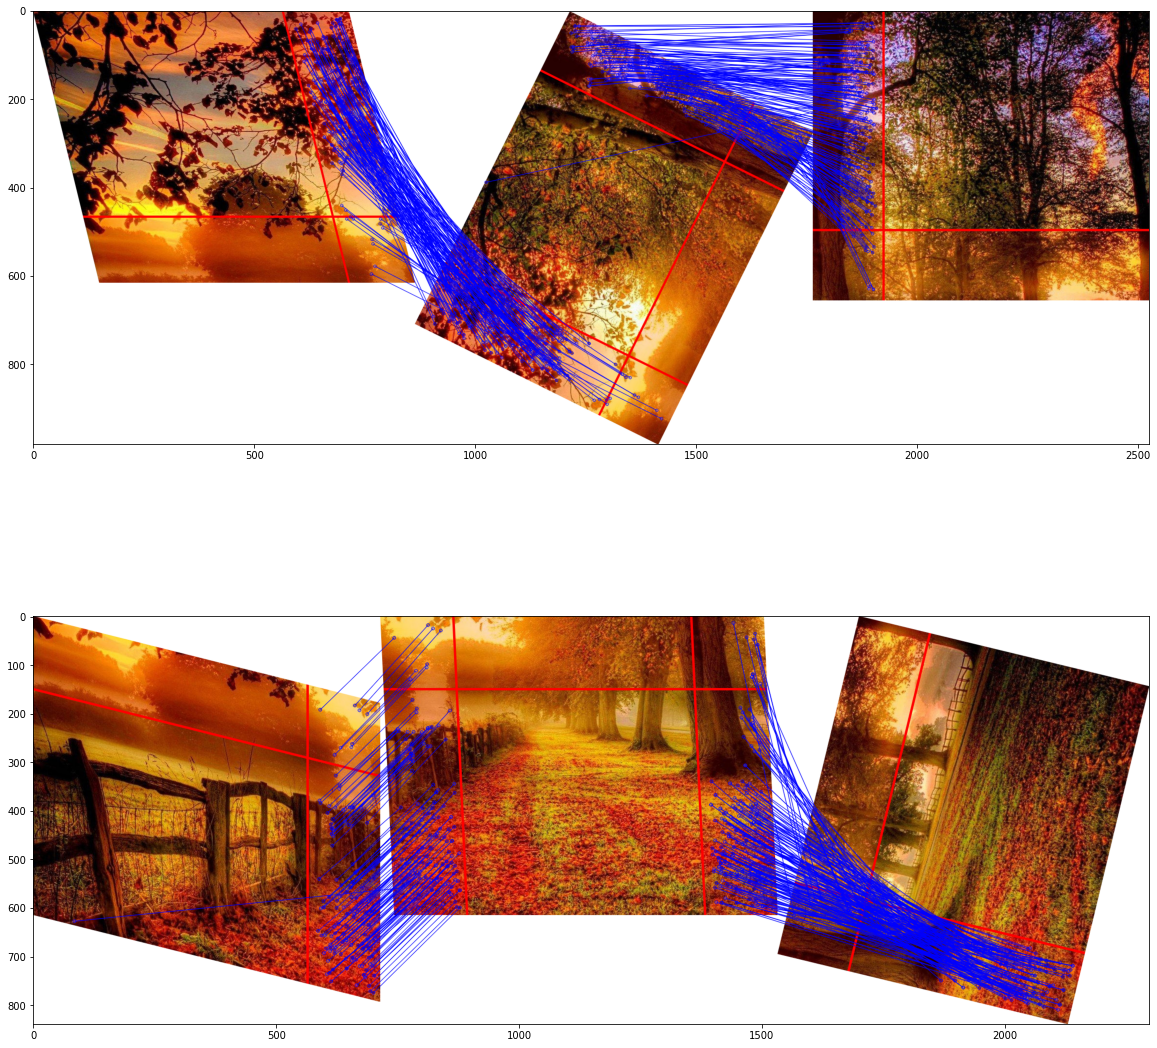

In [11]:
sift_kw = {
    "color": (255, 0, 255),
    "min_s": 3,
    "SIFT_draw": False
}
SIFT_splits = copy.deepcopy(splits)
data = SIFT_splits.apply(SIFT, **sift_kw)
data = [data[i * c_split:i * c_split + c_split] for i in range(r_split)]

view_matches(SIFT_splits, data)

### Join columns

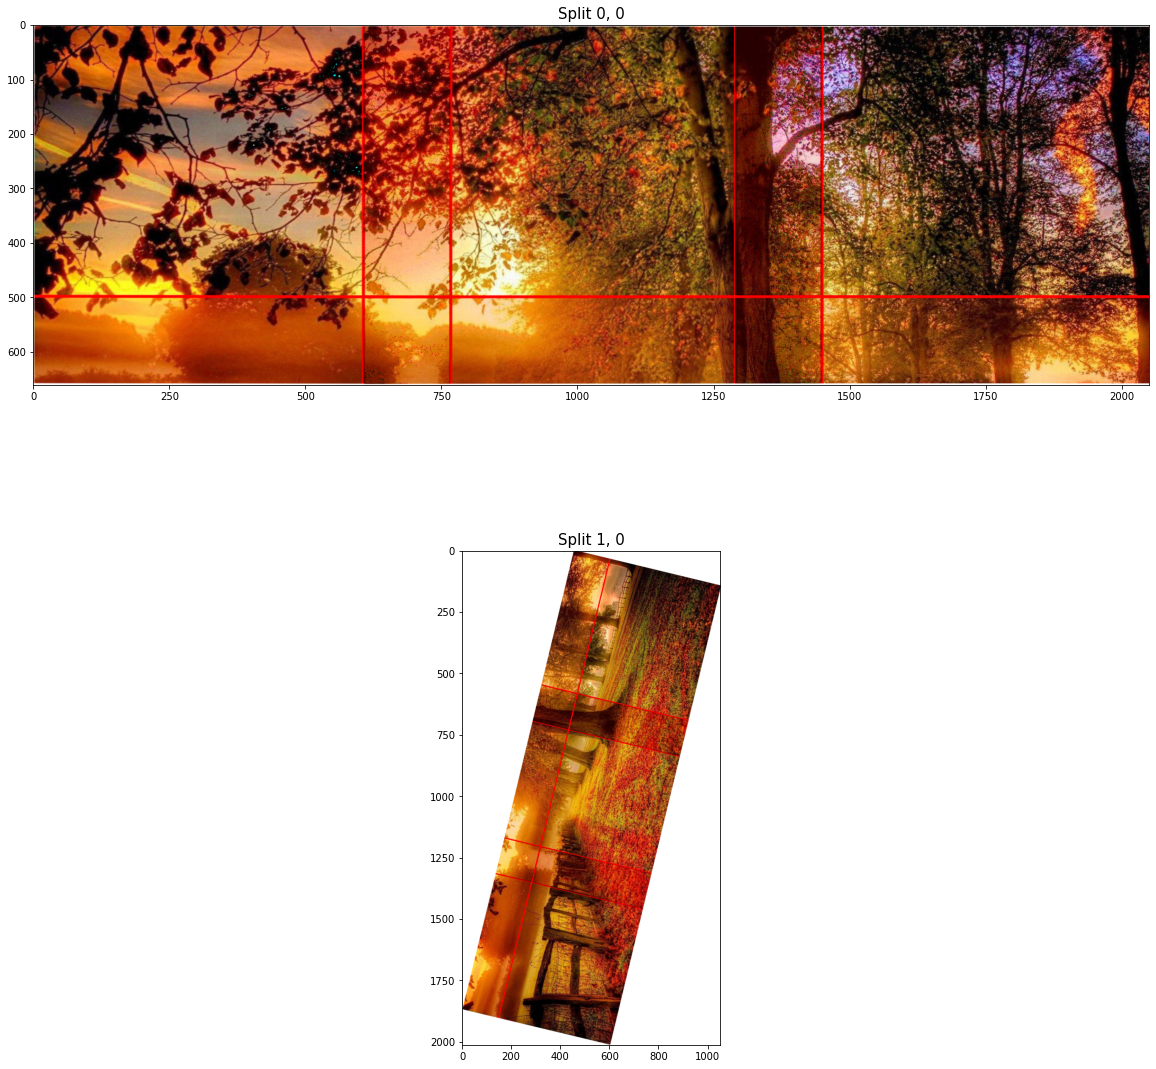

In [13]:
from utils import trim_padding
comp_splits = copy.deepcopy(SIFT_splits)

for i, s_row in enumerate(comp_splits):
    for j in range(c_split - 1):
        s1, s2 = s_row[0], s_row[j + 1]
        _, d1 = SIFT(s1, **sift_kw)
        _, d2 = SIFT(s2, **sift_kw)
        _, H = register([d1, d2], s1, s2)
        s_row[0] = composite(H, s1, s2) 
    comp_splits[i] = [s_row[0]]

comp_splits.apply_and_show(trim_padding)